<a href="https://colab.research.google.com/github/skduswn/captcha_deepLearning/blob/main/captcha_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/')
!pwd

/content/gdrive/MyDrive


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import ImageFolder
import random
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch import optim
from torchvision import datasets
from torchvision import utils
import torchvision
import zipfile
import cv2

In [ ]:
cd /content/gdrive/MyDrive/Dataset

/content/gdrive/MyDrive/Dataset


In [ ]:
ls

dataset_bold_split.zip


In [ ]:
 fname = 'dataset_bold_split.zip'
 data_zip = zipfile.ZipFile(fname)
 data_zip.extractall()
 
 data_zip.close()

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.RandomCrop(128, padding=8, padding_mode='reflect'),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize(*imagenet_stats,inplace=True)
])

valid_transforms = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
    transforms.Normalize(*imagenet_stats)
])
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
    transforms.Normalize(*imagenet_stats)
])

In [ ]:
dataset = ImageFolder(root='/content/gdrive/MyDrive/Dataset/data')

dataset_size = len(dataset)
dataset_size

5854

In [ ]:
print(dataset.classes) 

['0lower', '1lower', '2lower', '3lower', '4lower', '5lower', '6lower', '7lower', '8lower', '9lower', 'Aupper', 'Bupper', 'Cupper', 'Dupper', 'Eupper', 'Fupper', 'Gupper', 'Hupper', 'Iupper', 'Jupper', 'Kupper', 'Lupper', 'Mupper', 'Nupper', 'Oupper', 'Pupper', 'Qupper', 'Rupper', 'Supper', 'Tupper', 'Uupper', 'Vupper', 'Wupper', 'Xupper', 'Yupper', 'Zupper', 'alower', 'blower', 'clower', 'dlower', 'elower', 'flower', 'glower', 'hlower', 'ilower', 'jlower', 'klower', 'llower', 'mlower', 'nlower', 'olower', 'plower', 'qlower', 'rlower', 'slower', 'tlower', 'ulower', 'vlower', 'wlower', 'xlower', 'ylower', 'zlower']


In [ ]:
dict = {0:'0', 1:'1', 2:'2', 3:'3',4 :'4', 5:'5', 6:'6', 7:'7', 8:'8',9:'9', 
            10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 
            18:'I', 19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q',
            27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 
            36:'a', 37:'b', 38:'c', 39:'d', 40:'e', 41:'f', 42:'g', 43:'h', 
            44:'i', 45:'j', 46:'k', 47:'l', 48:'m', 49:'n', 50:'o', 51:'p', 52:'q',
            53:'r', 54:'s', 55:'t', 56:'u', 57:'v', 58:'w', 59:'x', 60:'y', 61:'z'}

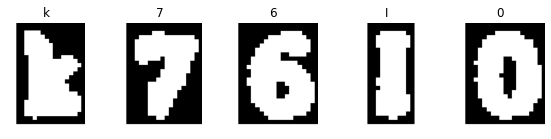

In [ ]:
pltsize = 2
plt.figure(figsize = (10*pltsize, pltsize))
for i in range(5):
  random_image = np.random.randint(0, dataset_size)
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(dataset[random_image][0], cmap='gray')
  plt.title(dict[dataset[random_image][1]])

In [ ]:
classes = dataset.classes
classes

In [ ]:
num_classes = len(dataset.classes)
num_classes

62

# Data Split

In [ ]:
test_size = 200
nontest_size = len(dataset) - test_size

nontest_df, test_df = random_split(dataset, [nontest_size, test_size])
len(nontest_df), len(test_df)

(5654, 200)

In [ ]:
val_size = 500
train_size = len(nontest_df) - val_size

train_df, val_df = random_split(nontest_df, [train_size, val_size])
len(train_df), len(val_df)

(5154, 500)

In [ ]:
test_df.dataset.transform = test_transforms
val_df.dataset.transform = valid_transforms
train_df.dataset.transform = train_transforms

In [ ]:
batch_size = 64

train_loader = DataLoader(train_df, batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_df, batch_size, shuffle=False,num_workers=2)
test_loader = DataLoader(test_df, batch_size, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch              # 1batch
        out = self(images)
        loss = F.cross_entropy(out, labels) # loss값 계산
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}"
        .format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        num_ftrs = self.network.fc.in_features
        # 62개의 클래스이기 때문에 구조 변경
        self.network.fc = nn.Linear(num_ftrs,num_classes)
    def forward(self, x):
        return torch.sigmoid(self.network(x))

# 정의한 모델 cuda device에 할당

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

cuda


In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
model = to_device(ResNet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# 학습을 위해 Data Device에 할당

In [ ]:
class DeviceDataLoader():
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
        
    def __iter__(self):
        for b in self.data_loader: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.data_loader)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# 학습

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            # learning rate 저장, 업데이트
            lrs.append(get_lr(optimizer))
            sched.step()
        # model.eval()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() #loss 평균
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_loader)]
history
epochs = 5
max_lr = 0.00005 
opt_func = torch.optim.Adam
print('epoch = ', epochs, 'max_lr = ', max_lr)
#print('epoch = ', epochs)
torch.cuda.empty_cache()

history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, opt_func=opt_func)


epoch =  5 max_lr =  5e-05


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00004, train_loss: 3.9462, val_loss: 3.6896, val_acc: 0.7281
Epoch [1], last_lr: 0.00005, train_loss: 3.5261, val_loss: 3.3907, val_acc: 0.8962
Epoch [2], last_lr: 0.00003, train_loss: 3.3246, val_loss: 3.2886, val_acc: 0.9440
Epoch [3], last_lr: 0.00001, train_loss: 3.2634, val_loss: 3.2627, val_acc: 0.9459
Epoch [4], last_lr: 0.00000, train_loss: 3.2488, val_loss: 3.2590, val_acc: 0.9498


In [ ]:
torch.save(model.state_dict(), 'captcha.pth')

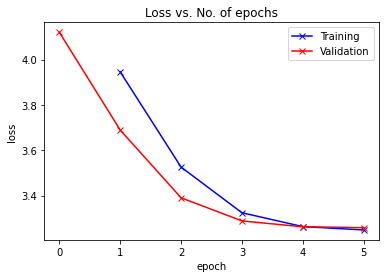

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

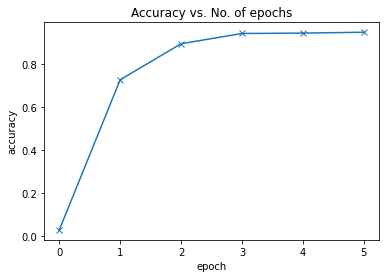

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
model = to_device(ResNet(), device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dataset/captcha.pth'))

<All keys matched successfully>

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, 1)
    return preds[0].item()

In [ ]:
evaluate(model, val_loader)['val_acc']

0.9448617696762085

Label: 1 , Predicted: 1


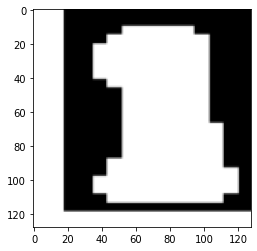

In [ ]:
img, label = val_df[0]
plt.imshow(img[0], cmap='gray')
label = dataset.classes[label]
predict = dataset.classes[predict_image(img, model)]
print('Label:', label[0:1], ', Predicted:', predict[0:1])

Label: Y , Predicted: Y
Label: T , Predicted: T
Label: g , Predicted: g
Label: c , Predicted: 0


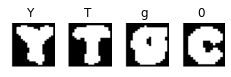

In [ ]:
pltsize = 1
plt.figure(figsize = (10*pltsize, pltsize))
result = []
for i in range(4):
  random_image = np.random.randint(0, len(test_df))
  img, label = test_df[random_image]
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(img[0], cmap='gray')
  label = dataset.classes[label]
  predict = dataset.classes[predict_image(img, model)]
  plt.title(predict[0:1])
  result.append(predict[0:1])
  print('Label:', label[0:1], ', Predicted:', predict[0:1])

# Captcha test data

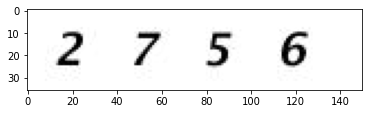

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/dataset3/00001.jpg', 0) 
plt.imshow(img, cmap='gray')

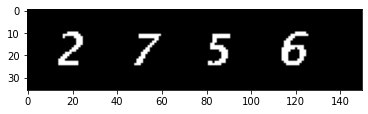

In [ ]:
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh1, cmap='gray')

In [ ]:
contours, hier = cv2.findContours(thresh1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
rects = [cv2.boundingRect(each) for each in contours]
rects = sorted(rects)
print(rects)
count=0
for rect in rects:
  padding=8
  cv2.rectangle(thresh1, (rect[0]-padding, rect[1]-padding),((rect[0]+rect[2])+padding, (rect[1]+rect[3])+padding), 255, 1)
  img_trim = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
  cv2.imwrite("/content/gdrive/MyDrive/dataset4/data/letter"+str(count)+".png", img_trim)
  count = count + 1
cv2.drawContours(thresh1, contours, -1, (255, 255, 0), 1)

[(14, 10, 11, 15), (48, 11, 12, 14), (81, 11, 10, 14), (114, 10, 12, 15)]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

4

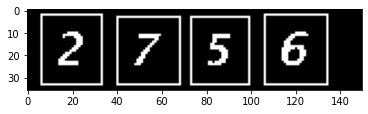

In [ ]:
plt.imshow(thresh1, cmap='gray')
len(contours)

In [ ]:
cd /content/gdrive/MyDrive/dataset4

/content/gdrive/MyDrive/dataset4


In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
tfs = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
    transforms.Normalize(*imagenet_stats)
])

In [ ]:
test_dataset = ImageFolder('/content/gdrive/MyDrive/dataset4', tfs)

In [ ]:
print(test_dataset.classes) #data 폴더 안에 있음

['data']


Predicted: v
Predicted: j
Predicted: 1
Predicted: 2
captcha result : vj12


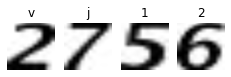

In [ ]:
pltsize = 1
plt.figure(figsize = (10*pltsize, pltsize))
result = []
for i in range(len(test_dataset)):
  img, label = test_dataset[i]
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(img[0], cmap='gray')
  predict = dataset.classes[predict_image(img, model)]
  plt.title(predict[0:1])
  result.append(predict[0:1])
  print('Predicted:', predict[0:1])
print('captcha result : '+''.join(result))